<a href="https://colab.research.google.com/github/pat25bk/deep-learning-2023/blob/main/SqueezeNet_ImageNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras-applications

In [ ]:
from keras_applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout
import warnings
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.models import Model
# from keras.engine.topology import get_source_inputs
from keras.utils import get_source_inputs
from keras.utils import get_file
from keras.utils import layer_utils


sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

WEIGHTS_PATH = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_NO_TOP = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Modular function for Fire Node

def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3

    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x


# Original SqueezeNet from paper.

def SqueezeNet(include_top=True, weights='imagenet',
               input_tensor=None, input_shape=None,
               pooling=None,
               classes=1000):
    """Instantiates the SqueezeNet architecture.
    """

    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')


    input_shape = _obtain_input_shape(input_shape,
                                      default_size=227,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor


    x = Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)

    if include_top:
        # It's not obvious where to cut the network...
        # Could do the 8th or 9th layer... some work recommends cutting earlier layers.

        x = Dropout(0.5, name='drop9')(x)

        x = Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
        x = Activation('relu', name='relu_conv10')(x)
        x = GlobalAveragePooling2D()(x)
        x = Activation('softmax', name='loss')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling=='max':
            x = GlobalMaxPooling2D()(x)
        elif pooling==None:
            pass
        else:
            raise ValueError("Unknown argument for 'pooling'=" + pooling)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = Model(inputs, x, name='squeezenet')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')

        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model

In [ ]:
!pip install git+https://github.com/rcmalli/keras-squeezenet.git

In [ ]:
!pip install keras-applications

In [ ]:
from keras_squeezenet import SqueezeNet

In [ ]:
import numpy as np
# from keras_squeezenet import SqueezeNet
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
import keras.utils as image
from tensorflow.keras.preprocessing.image import load_img

In [ ]:
import keras.backend as K
import matplotlib.pyplot as plt
%matplotlib inline

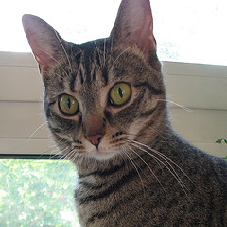

In [ ]:
# Load and preprocessing example image
img = load_img('/content/cat.jpeg', target_size=(227, 227))
display(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [ ]:
model = SqueezeNet()
preds = model.predict(x)

print('Predicted:', decode_predictions(preds))

# Randomly initialized weights
The weights should look random, and it should not be able to predict the correct class

In [ ]:
# Get weights that are not trained (i.e., randomly initialized)
model = SqueezeNet(weights=None)

(3, 3, 3, 64)
float32
[[[ 0.01138324  0.05282661 -0.02547917]
  [-0.01726382  0.02048182  0.05858862]
  [-0.06311589  0.04868625  0.04245685]]

 [[-0.08311982  0.09416923 -0.08774233]
  [-0.06371658 -0.07454059 -0.02155967]
  [ 0.0798426  -0.04316401  0.07597002]]

 [[ 0.06306963  0.07104182 -0.04454263]
  [-0.06742199  0.02597634 -0.02822354]
  [-0.00821202  0.03093815  0.04764009]]]


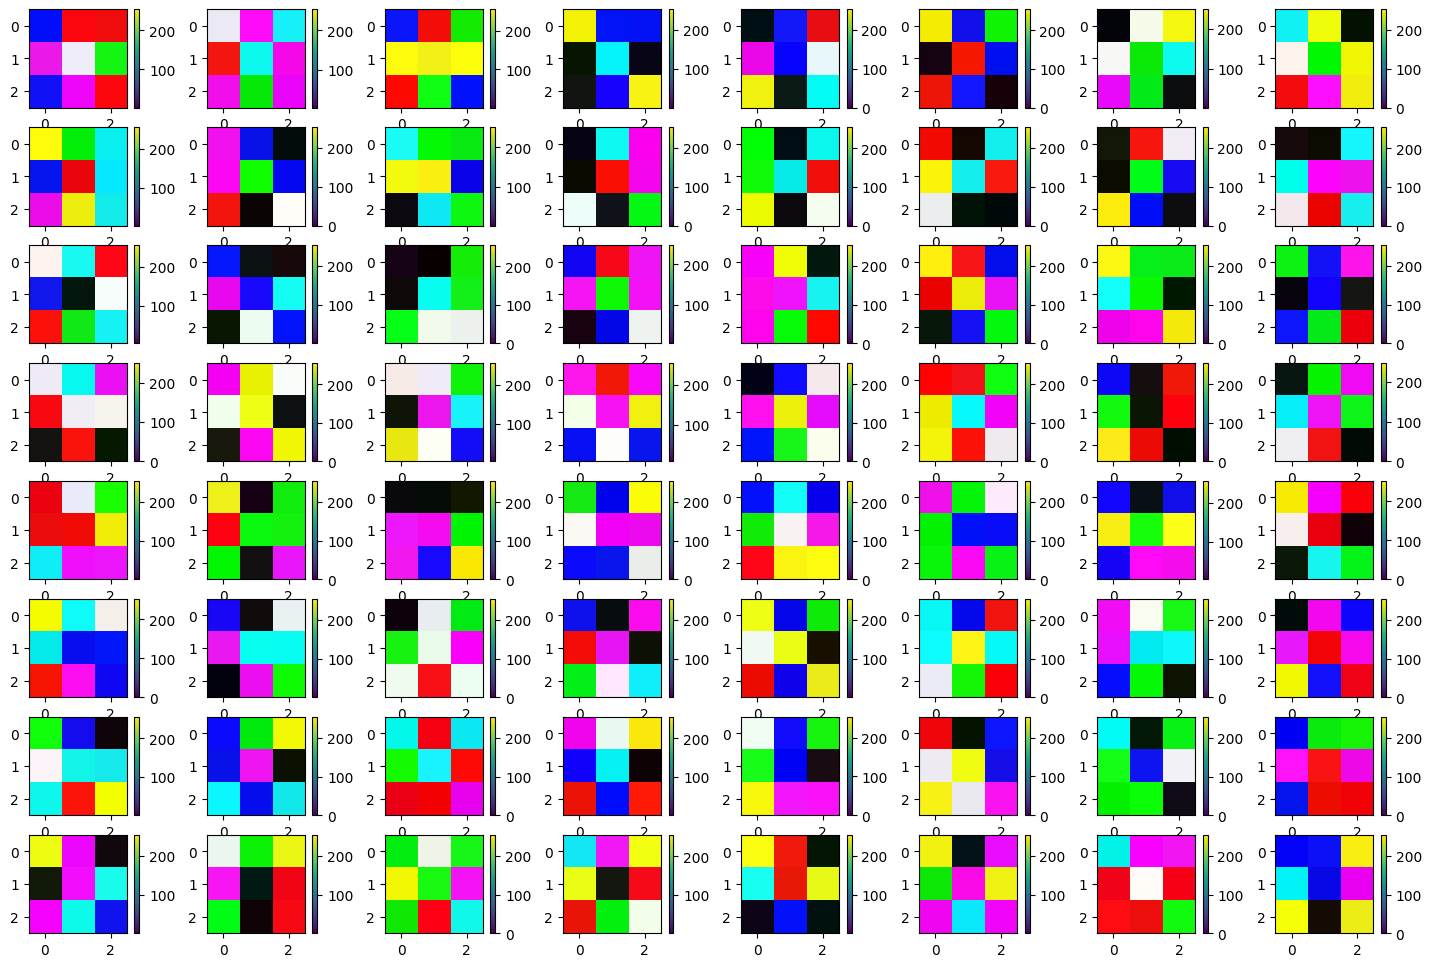

In [ ]:
W = K.eval(model.weights[0])
print(W.shape)
print(W.dtype)
print(W[:,:,:,0])
plt.figure(figsize=(18,12))
for idx in range(W.shape[-1]):
    plt.subplot(8,8,idx+1)
    plt.imshow((W[:,:,:,idx]*255).astype(np.uint8)); plt.colorbar()

# Weights pretrained over ImageNet
Check to make sure we can get the pretrained weights. The weights should have some structure, and the classification should be pretty good, since the model is already trained.

In [ ]:
# Get weights that are trained over ImageNet.
model = SqueezeNet(weights='imagenet')

(3, 3, 3, 64)
float32
[[[ 0.25723463  0.550187    0.3146835 ]
  [ 0.35936555  0.67822134  0.42987484]
  [ 0.20342727  0.4646542   0.31338826]]

 [[-0.10043427 -0.14836277 -0.15516894]
  [-0.15803897 -0.27109194 -0.21141443]
  [-0.09803903 -0.18449612 -0.07712273]]

 [[-0.07055681 -0.20943047 -0.11449682]
  [-0.18863212 -0.46400833 -0.24798788]
  [-0.19638601 -0.44788226 -0.22560848]]]


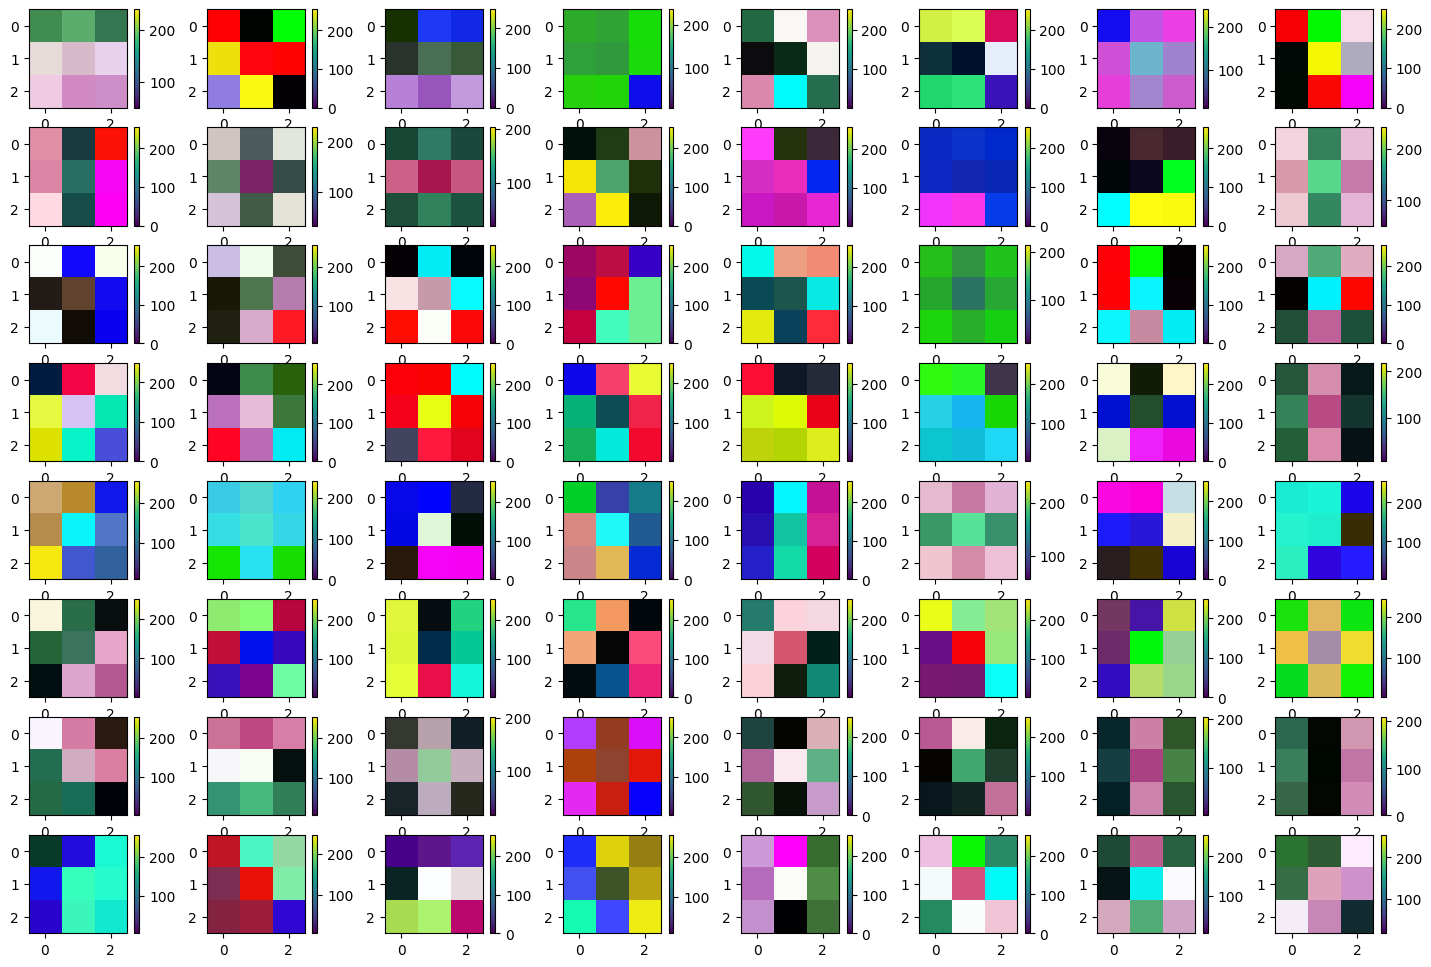

In [ ]:
W = K.eval(model.weights[0])
print(W.shape)
print(W.dtype)
print(W[:,:,:,0])
plt.figure(figsize=(18,12))
for idx in range(W.shape[-1]):
    plt.subplot(8,8,idx+1)
    plt.imshow((W[:,:,:,idx]*255).astype(np.uint8)); plt.colorbar()

# Imagenet-Pretrained Squeezenet Inference

In [ ]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds))
# Alright! These look good!

1/1 [==============================] - 0s 329ms/step
Predicted: [[('n02123045', 'tabby', 0.8213436), ('n02124075', 'Egyptian_cat', 0.121806435), ('n02123159', 'tiger_cat', 0.05682099), ('n02127052', 'lynx', 2.2597957e-05), ('n02129604', 'tiger', 5.1768375e-06)]]


# Weights for no_top
Here we will save the weights for when include_top is False. We'll do this by popping off the last few layers to get the layers we want.